In [1]:
import os

os.chdir("../../")

import statsmodels.tsa.statespace.sarimax as smx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.data_handling import ingestion

sns.set_theme(context="paper", font_scale=2.0, style="whitegrid")

In [2]:
ts_data = ingestion.read_combined().dropna()

d:\anaconda3\envs\ba\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
d:\anaconda3\envs\ba\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
d:\anaconda3\envs\ba\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
d:\anaconda3\envs\ba\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


### Train and test set

In [3]:
X = ts_data.drop(columns=["consumption", "temperature"])
y = ts_data["consumption"]

X_train = X[:"2020"]
X_test = X["2021":]
y_train = y[:"2020"]
y_test = y["2021":]

# AutoReg with lag 1 and external regressors
model = smx.SARIMAX(y_train, lags=[1, 7], exog=X_train)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            consumption   No. Observations:                 1553
Model:               SARIMAX(1, 0, 0)   Log Likelihood              -21149.403
Date:                Sat, 13 May 2023   AIC                          42316.806
Time:                        16:07:32   BIC                          42364.937
Sample:                    10-01-2016   HQIC                         42334.705
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
temperature_capped -1.297e+05   2929.704    -44.285      0.000   -1.35e+05   -1.24e+05
imbalance_prices    1.777e+04    233.332     76.163      0.000    1.73e+04    1.82e+04
electricity_price   6616.6323    578.557     11.436      0.000    5482.682    7750.583
crude_oil_price     2.328e+04   4222.190      5.513      0.000     1.5e+04    3.16e+04
eua_price           2.851e+04   1.18e+04      2.419      0.016    5407.947    5.16e+04
storage_levels      6301.6923   1726.808      3.649      0.000    2917.210    9686.175
weekend            -1.487e+04    1.1e+04     -1.355      0.176   -3.64e+04    6645.783
ar.L1                  0.9655      0.009    110.268      0.000       0.948       0.983
sigma2              4.768e+10      0.017   2.85e+12      0.000    4.77e+10    4.77e+10
===================================================================================
Ljung-Box (L1) (Q):                  17.58   Jarque-Bera (JB):              1644.39
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.79   Skew:                            -0.13
Prob(H) (two-sided):                  0.01   Kurtosis:                         8.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.09e+27. Standard errors may be unstable.
"""

In [4]:
X_static_regressors = X.copy()
X_static_regressors.loc["2021-01-01":, X_static_regressors.columns.drop("temperature_capped")] = float("nan")
X_static_regressors = X_static_regressors.fillna(method="ffill")

In [5]:
predictions = results.get_prediction(start=0, end="2022-11-28", exog=X_test)
predictions_static_regressors = results.get_prediction(start=0, end="2022-11-28", exog=X_static_regressors["2021":])
predictions_cofindence_intervals = predictions.conf_int()
predictions_static_regressors_confidence_intervals = predictions_static_regressors.conf_int()

modelled_consumption = predictions.predicted_mean
modelled_consumption_static_regressors = predictions_static_regressors.predicted_mean

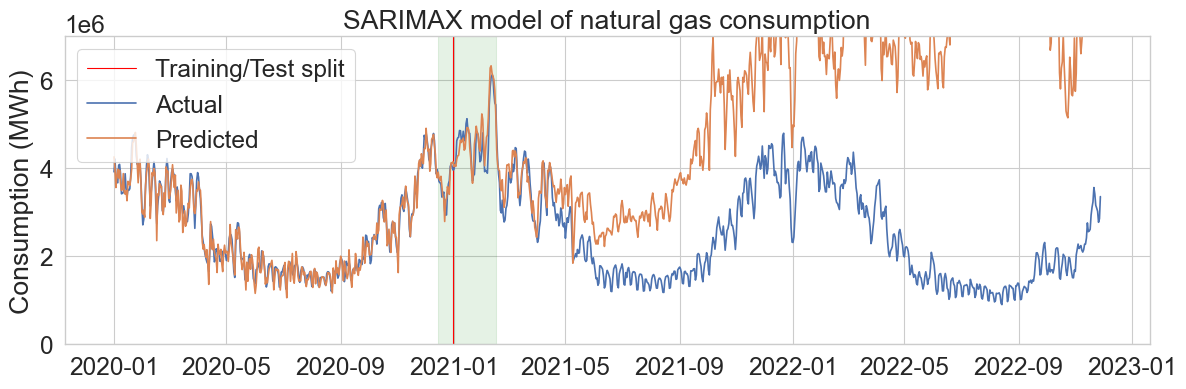

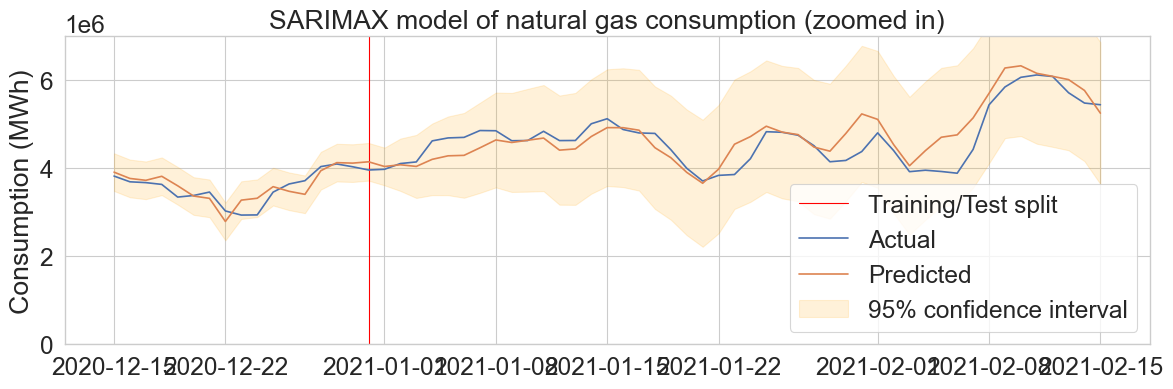

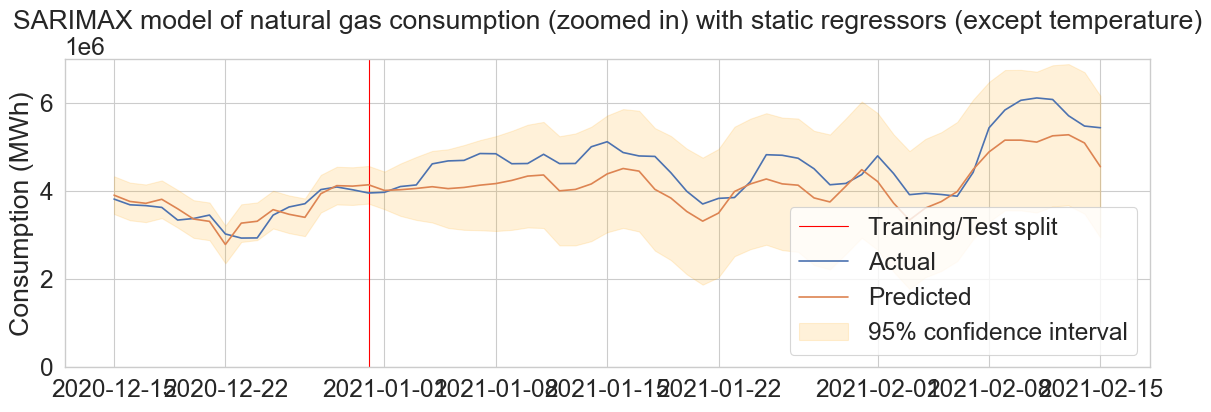

In [6]:
# Plot 1 - multiple years
fig, ax = plt.subplots(figsize=(14, 4))

ax.axvline(
    pd.Timestamp("2020-12-31"), color="red", linewidth=0.8, label="Training/Test split"
)
ax.axvspan(
    pd.Timestamp("2020-12-15"), pd.Timestamp("2021-02-15"), color="green", alpha=0.1
)
ax.plot(y["2020":], label="Actual")
ax.plot(modelled_consumption["2020":], label="Predicted")
ax.set_ylabel("Consumption (MWh)")
ax.legend()
ax.set_title("SARIMAX model of natural gas consumption")
ax.set_ylim(0, 7 * 10**6)

# Save plot
fig.savefig("diagrams/modelling_003_001.svg", format="svg", bbox_inches="tight")

# Plot 2 - zoomed in
fig, ax2 = plt.subplots(figsize=(14, 4))

ax2.axvline(
    pd.Timestamp("2020-12-31"), color="red", linewidth=0.8, label="Training/Test split"
)
ax2.plot(y["2020-12-15":"2021-02-15"], label="Actual")
ax2.plot(modelled_consumption["2020-12-15":"2021-02-15"], label="Predicted")
ax2.fill_between(
    predictions_cofindence_intervals.loc["2020-12-15":"2021-02-15"].iloc[:, 0].index,
    predictions_cofindence_intervals.loc["2020-12-15":"2021-02-15"].iloc[:, 0],
    predictions_cofindence_intervals.loc["2020-12-15":"2021-02-15"].iloc[:, 1],
    color="orange",
    alpha=0.15,
    label="95% confidence interval",
)
ax2.set_ylabel("Consumption (MWh)")
ax2.legend()
ax2.set_title("SARIMAX model of natural gas consumption (zoomed in)")
ax2.set_ylim(0, 7 * 10**6)

# Save plot
fig.savefig("diagrams/modelling_003_002.svg", format="svg", bbox_inches="tight")

# Plot 3 - zoomed in with static regressors
fig, ax3 = plt.subplots(figsize=(14, 4))

ax3.axvline(
    pd.Timestamp("2020-12-31"), color="red", linewidth=0.8, label="Training/Test split"
)
ax3.plot(y["2020-12-15":"2021-02-15"], label="Actual")
ax3.plot(
    modelled_consumption_static_regressors["2020-12-15":"2021-02-15"], label="Predicted"
)
ax3.fill_between(
    predictions_static_regressors_confidence_intervals.loc["2020-12-15":"2021-02-15"].iloc[:, 0].index,
    predictions_static_regressors_confidence_intervals.loc["2020-12-15":"2021-02-15"].iloc[:, 0],
    predictions_static_regressors_confidence_intervals.loc["2020-12-15":"2021-02-15"].iloc[:, 1],
    color="orange",
    alpha=0.15,
    label="95% confidence interval",
)
ax3.set_ylabel("Consumption (MWh)")
ax3.legend()
ax3.set_title(
    "SARIMAX model of natural gas consumption (zoomed in) with static regressors (except temperature)"
)
ax3.set_ylim(0, 7 * 10**6)

# Save plot
fig.savefig("diagrams/modelling_003_003.svg", format="svg", bbox_inches="tight")

In [7]:
# Mean Absolute Percentage Error (MAPE) for 60days after training data cutoff
mape = (
    abs(y["2021-01-01":"2021-02-28"] - modelled_consumption["2021-01-01":"2021-02-28"])
    / y["2021-01-01":"2021-02-28"]
).mean() * 100

mape_static_regressors = (
    abs(y["2021-01-01":"2021-02-28"] - modelled_consumption_static_regressors["2021-01-01":"2021-02-28"])
    / y["2021-01-01":"2021-02-28"]
).mean() * 100

mape_static_regressors_14days = (
    abs(y["2021-01-01":"2021-01-14"] - modelled_consumption_static_regressors["2021-01-01":"2021-01-14"])
    / y["2021-01-01":"2021-01-14"]
).mean() * 100

print(f"MAPE: {mape:.2f}%")
print(f"MAPE (static regressors): {mape_static_regressors:.2f}%")
print(f"MAPE (static regressors, 14 days): {mape_static_regressors_14days:.2f}%")

MAPE: 7.69%
MAPE (static regressors): 9.46%
MAPE (static regressors, 14 days): 9.87%
